In [1]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
import jax.numpy as jnp
from jax import jit
from functools import partial
import time as tm
# Bi modules
m = bi(platform='cpu')


jax.local_device_count 32


# Networks Models

## Rethinking

In [7]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)

m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.fit(model) 
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 260.89it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 5.9322 seconds


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Trying bi functions

In [42]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = m.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = m.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.fit(model) 
res2 = az.from_numpyro(m.sampler)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.74it/s, 255 steps of size 2.22e-02. acc. prob=0.93]


BI took: 6.6370 seconds


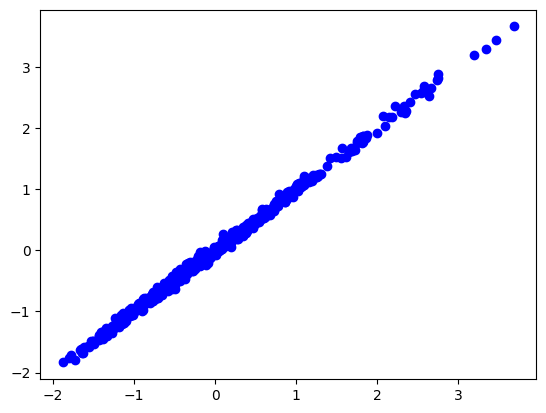

In [43]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0], marker='o', linestyle='None', color='b', label='Posteriors')

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1], marker='o', linestyle='None', color='b', label='Posteriors')

## STRAND

### Sender receiver model

#### STRAND simulation

In [18]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Mass = rbern(N_id, 0.4)

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))
#################################################### Simulate SBM + SRM network
sr_effects_1 = c(-1.9, 1.3)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = c(0,0),  
                         sr_sigma = c(2.2, 1.7) , 
                         sr_rho = 0.55,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = NULL,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = NULL
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson")

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ 1,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'tests/STRAND/STRAND sim sr only.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 113.0 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.931"  "1.579"   "2.383"  
[2,] "focal effects coeffs (out-degree), Mass" "-1.467" "-2.369"  "-0.769" 
     Mean     SD     
[1,] "1.96"   "0.254"
[2,] "-1.456" "0.501"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.345" "1.101"   "1.58"   
[2,] "target effects coeffs (in-degree), Mass" "1.45"  "0.797"   "2.02"   
     Mean    SD     
[1,] "1.359" "0.166"
[2,] "1.425" "0.386"

$`Dyadic effects`
     Variable            Median  HPDI:0.05 HPDI:0.95 Mean    SD     
[1,] "dya

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd8fb80.stan', line 81, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd8fb80.stan', line 81, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the s

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(STRAND)
load('tests/STRAND/STRAND sim sr only.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "1.931"  "1.579"   "2.383"  
[2,] "focal effects coeffs (out-degree), Mass" "-1.467" "-2.369"  "-0.769" 
     Mean     SD     
[1,] "1.96"   "0.254"
[2,] "-1.456" "0.501"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.345" "1.101"   "1.58"   
[2,] "target effects coeffs (in-degree), Mass" "1.45"  "0.797"   "2.02"   
     Mean    SD     
[1,] "1.359" "0.166"
[2,] "1.425" "0.386"

$`Dyadic effects`
     Variable            Median  HPDI:0.05 HPDI:0.95 Mean    SD     
[1,] "dyadic effects sd" "0.977" "0.842"   "1.062"   "0.975" "0.066"

$`Other estimates`
     Variable                                            Median   HPDI:0.05
[1,] "focal-target effects rho (generalized recipocity)" "0.531"  "0.325"  
[2,] "dyadic effects rho (dyad

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [3]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
id = r.randint(1, data['N_id'][0]-1)


ids = jnp.arange(0,data['N_id'][0])
idx = m.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))
@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model(idx, result_outcomes,focal_individual_predictors, target_individual_predictors):
    N_id = ids.shape[0]

    ## Block ---------------------------------------
    B = bi.dist.normal(logit(0.1/jnp.sqrt(N_id)), 2.5, shape=(1,), name = 'block')

    #SR ---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    ### Dyadic--------------------------------------  
    #dr, dr_raw, dr_sigma, dr_L = m.net.dyadic_random_effects(idx.shape[0], cholesky_density = 2)# shape = n dyads
    dr = m.net.dyadic_effect(shape = idx.shape[0])
    ## SR ---------------------------------------                                                      
    lk('Y', Poisson(jnp.exp(B + sr + dr), is_sparse = False), obs=result_outcomes)  

    ## NBDA -----------------------------     

m.data_on_model = dict(
    idx = idx,
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors'],
)

m.fit(model) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'block[0]',]]
# focal_effects = -1.9,
# target_effects =  1.3
# block =  -4

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:17<00:00, 55.89it/s, 127 steps of size 2.82e-02. acc. prob=0.92]


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],-1.47,0.58,-2.43,-0.55
target_effects[0],1.43,0.37,0.88,2.04
block[0],-4.05,0.57,-4.88,-3.08


In [22]:
%%R
getwd()
library(STRAND)
load('tests/STRAND/STRAND sim sr only.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)


                               res.summary.Variable res.summary.Median
1                                  focal effects sd              1.931
2           focal effects coeffs (out-degree), Mass             -1.467
3                                 target effects sd              1.345
4           target effects coeffs (in-degree), Mass               1.45
5                                 dyadic effects sd              0.977
6 focal-target effects rho (generalized recipocity)              0.531
7            dyadic effects rho (dyadic recipocity)              0.783
8                             intercept, any to any             -3.933


### Sender receiver & dyadic effects model

#### Method accuracy demonstration.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library(STRAND)
dr_raw = matrix(0, ncol = 3, nrow = 3)
dr_raw[1,] = c(0, 0.6, 0.66)
dr_raw[2,] = c(0.1, 0, 0.9)
dr_raw[3,] = c(-0.5, 0.24, 0)
tl = lower.tri(dr_raw, diag = FALSE)
tu = upper.tri(dr_raw, diag = FALSE)
dr2 = cbind(dr_raw[tl], dr_raw[tu])
d.sigma = c(0.2,0.2)

Rho = matrix(1, ncol = 2, nrow = 2)
rho = 0.73
Rho[1,2] = rho
Rho[2,1] = rho
L = chol(Rho)

R = NULL
for( a in 1:nrow(dr2)){
  R[[a]] = (L %*% dr2[a,]) * d.sigma
}
R


[[1]]
           [,1]
[1,] 0.10760000
[2,] 0.08201366

[[2]]
            [,1]
[1,] -0.00364000
[2,]  0.09021502

[[3]]
          [,1]
[1,] 0.1794000
[2,] 0.1230205



Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [6]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
L = jnp.array(ro.globalenv['L']).reshape(2,2)
dr2 = jnp.array(ro.globalenv['dr2']).reshape(3,2).T
d_sigma = jnp.array(ro.globalenv['d.sigma'])
(L @ dr2).T * d_sigma

Array([[ 0.10760001,  0.08201366],
       [-0.00363999,  0.09021502],
       [ 0.17940001,  0.12302049]], dtype=float32)

Code used in function is:

In [7]:
dr_raw =  dist.normal(0, 1, shape=(2, 3), name = 'dr_raw', sample = True)
dr_sigma = dist.exponential(1, shape=(1,), name = 'dr_sigma', sample = True )
dr_L = dist.lkjcholesky(2, 2, name = 'dr_L', sample = True)
rf = ((dr_L @ dr_raw).T * jnp.repeat(dr_sigma, 2))
rf

Array([[ 0.10182459,  0.6520411 ],
       [-0.695662  ,  0.24218999],
       [ 0.35203034, -0.11920679]], dtype=float32)

#### Simulated data

In [27]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0  
dr_sigma = 1.5
dr_rho= 0.6

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1                         
                         )        
################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "poisson", dyadic_covariates=list(Kinship=Kinship))

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'tests/STRAND/STRAND sim sr dyad.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 476.7 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.16"  "1.766"   "2.612"  
[2,] "focal effects coeffs (out-degree), Mass" "1.885" "1.095"   "2.818"  
     Mean    SD     
[1,] "2.177" "0.263"
[2,] "1.867" "0.56" 

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.859" "1.535"   "2.19"   
[2,] "target effects coeffs (in-degree), Mass" "0.712" "-0.142"  "1.472"  
     Mean    SD     
[1,] "1.876" "0.202"
[2,] "0.684" "0.485"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyad

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd8fb80.stan', line 81, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpw5c4ik/model-91337dd8fb80.stan', line 81, column 4 to column 43)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the s

#### Send simulation to python

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()
library(STRAND)
load('tests/STRAND/STRAND sim sr dyad.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.16"  "1.766"   "2.612"  
[2,] "focal effects coeffs (out-degree), Mass" "1.885" "1.095"   "2.818"  
     Mean    SD     
[1,] "2.177" "0.263"
[2,] "1.867" "0.56" 

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.859" "1.535"   "2.19"   
[2,] "target effects coeffs (in-degree), Mass" "0.712" "-0.142"  "1.472"  
     Mean    SD     
[1,] "1.876" "0.202"
[2,] "0.684" "0.485"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.497" "1.397"   "1.577"   "1.496"
[2,] "dyadic effects coeffs, Kinship" "0.673" "0.058"   "1.27"    "0.67" 
     SD     
[1,] "0.055"
[2,] "0.378"

$`Other estimates`
     Variable                                            Median  

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [4]:
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'].reshape(data['N_id'][0],data['N_id'][0]).T
exposure = data['exposure'].reshape(data['N_id'][0],data['N_id'][0]).T

def model(ids, result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors):

    # Block ---------------------------------------
    B = bi.dist.normal(BI.logit(0.1/jnp.sqrt(ids.shape[0])), 2.5, shape=(1,), name = 'block')
    
    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)

    lk('Y', Poisson(jnp.exp(B + sr + dr)), obs=result_outcomes)

m.data_on_model = dict(
    ids = jnp.arange(0,data['N_id'][0]),
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = m.net.prepare_dyadic_effect(kinship), # Can be a jax array of multiple dimensions
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.fit(model, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]', 'block[0]', 'sr_sigma[0]', 'sr_sigma[1]']]
#summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]', 'block[0]', 'sr_sigma[0]', 'sr_sigma[1]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2
# block =  -4

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [01:09<00:00, 14.47it/s, 1023 steps of size 5.16e-03. acc. prob=0.91]


,mean,sd,hdi_5.5%,hdi_94.5%
focal_effects[0],1.89,0.51,1.09,2.73
target_effects[0],0.64,0.53,-0.08,1.62
dyad_effects[0],0.68,0.38,0.03,1.22
block[0],-4.10,0.60,-5.08,-3.21
sr_sigma[0],2.20,0.25,1.76,2.51
sr_sigma[1],1.87,0.22,1.56,2.24


In [38]:
%%R
getwd()
library(STRAND)
load('tests/STRAND/STRAND sim sr dyad.Rdata')
data.frame(
res$summary$Variable,
res$summary$Median)

                               res.summary.Variable res.summary.Median
1                                  focal effects sd               2.16
2           focal effects coeffs (out-degree), Mass              1.885
3                                 target effects sd              1.859
4           target effects coeffs (in-degree), Mass              0.712
5                                 dyadic effects sd              1.497
6                    dyadic effects coeffs, Kinship              0.673
7 focal-target effects rho (generalized recipocity)              0.589
8            dyadic effects rho (dyadic recipocity)              0.503
9                             intercept, any to any             -3.974


### Sender receiver,  dyadic effects & block model
#### Simulation

In [4]:
%load_ext rpy2.ipython

In [3]:
%%R 
#####################################
#
#   Binomial Analyses - Simulated data  
#
########################################

# Clear working space
rm(list = ls())
set.seed(1)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)


# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.6
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))

#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         mode="poisson",                  
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )        

################################################### Organize for model fitting
model_dat = make_strand_data(outcome=list(G$network),  block_covariates=groups_f, individual_covariates=data.frame(Mass=Mass), 
                           dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),  outcome_mode = "poisson", exposure=list(G$samps))

# Model the data with STRAND
fit =  fit_block_plus_social_relations_model(data=model_dat,
                            block_regression = ~ Merica + Quantum,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1, refresh = 500,
                                                          iter_warmup = 500, iter_sampling = 500,
                                                          max_treedepth = NULL, adapt_delta = .9)
)

# Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'tests/STRAND/STRAND sim sr dr block.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 527.9 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.204" "1.845"   "2.624"  
[2,] "focal effects coeffs (out-degree), Mass" "1.652" "0.716"   "2.472"  
     Mean    SD     
[1,] "2.227" "0.257"
[2,] "1.636" "0.544"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.516" "1.165"   "1.849"  
[2,] "target effects coeffs (in-degree), Mass" "0.842" "0.072"   "1.508"  
     Mean    SD     
[1,] "1.534" "0.22" 
[2,] "0.803" "0.453"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyad

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
Loading required package: cmdstanr
This is cmdstanr version 0.8.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.35.0
- CmdStan version: 2.35.0
Loading required package: posterior
This is posterior version 1.6.0

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_co

#### Send simulation to python

In [4]:
%load_ext rpy2.ipython

In [7]:
%%R
getwd()
library(STRAND)

load('STRAND sim sr dr block.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.204" "1.845"   "2.624"  
[2,] "focal effects coeffs (out-degree), Mass" "1.652" "0.716"   "2.472"  
     Mean    SD     
[1,] "2.227" "0.257"
[2,] "1.636" "0.544"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.516" "1.165"   "1.849"  
[2,] "target effects coeffs (in-degree), Mass" "0.842" "0.072"   "1.508"  
     Mean    SD     
[1,] "1.534" "0.22" 
[2,] "0.803" "0.453"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.47"  "1.326"   "1.629"   "1.477"
[2,] "dyadic effects coeffs, Kinship" "0.423" "-0.491"  "1.331"   "0.432"
     SD     
[1,] "0.1"  
[2,] "0.578"

$`Other estimates`
      Variable                                            Median 

Bei diesem Spaziergang an den STRAND scharfen wir unsere Sinne fur die Sternbilder hoch am Himmel!
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


#### Model

In [8]:
# Building model and sampling it ------------------
from BI import bi
import jax.numpy as jnp
from jax import jit
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'][0,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
dyad2 = data['dyadic_predictors'][1,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
Any = data['block_predictors'][0,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Merica  = data['block_predictors'][1,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Quantum  = data['block_predictors'][2,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
ids = jnp.arange(0,data['N_id'][0])
idx = m.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))

jax.local_device_count 32


# SRM class

## Import data to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
getwd()
load('BOB.RData')
dim(fit1$block_set)
F = fit1$focal_set
T = fit1$target_set
D = fit1$dyad_set
B = fit1$block_set
Net = fit1$outcomes[,,1]


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
import jax.numpy as jnp
import jax
from jax import jit
from BI import bi
from BI.Models.SRM import SRM
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as numpy2ri
import numpy as np
numpy2ri.activate()


def import_with_shape(name):
    # F already exists in R globalenv after load('test.RData')
    F_r = ro.globalenv[name]   # This is an rpy2 object (likely IntVector/FloatVector with dim attr)
    F_np = np.array(F_r)
    return F_np
focal_predictors = import_with_shape('F')
target_predictors = import_with_shape('T')
dyadic_predictors = jnp.array(import_with_shape('D'))
block_predictors = jnp.array(import_with_shape('B'))
network = import_with_shape('Net')

jax.local_device_count 32


In [4]:
#from BI import bi
#from BI.Models.SRM import SRM
#srm = SRM(network = network, print_info=False)
#srm.import_focal_predictors(focal_predictors)
#srm.import_receiver_predictors(target_predictors)
#srm.import_dyadic_predictors(dyadic_predictors, intercept_present = True)
#srm.import_block_predictors(block_predictors, index1=True)
#
#m.data_on_model = dict(
#    Block_edgl = srm.Block_edgl, 
#    dat_B = srm.dat_B, 
#    focal_predictors=srm.focal_predictors, 
#    receiver_predictors=srm.receiver_predictors, 
#    dyadic_predictors = srm.dyadic_predictors, 
#    network = srm.network)
#m.fit(srm.model)

In [5]:
import pandas as pd

def logit(x):
    return jnp.log(x / (1 - x))
class SRM:
    def __init__(self, network, print_info = False):
        
        if network.ndim!=2:
             print('Error: Network dimension must be 2')

        self.N_id = network.shape[0]        
        self.N_dyad = (self.N_id * (self.N_id - 1) )/ 2
        self.N_dyad = int(self.N_dyad)
        self.network = m.net.mat_to_edgl(network)
        self.print_info = print_info
        self.focal_predictors = None
        self.focal_predictors_names = None
        self.receiver_predictors = None
        self.receiver_predictors_names = None
        self.dyadic_predictors = None
        self.dyadic_predictors_names = None
        self.exposure = None
        self.block_predictors = None
        self.block_predictors_names = None
        self.blocks_base_rate = None     
        self.block_intercept = None
        self.dyadic_intercept = None
        
    def import_sender_predictors(self, sender_predictors, names = None):
        if self.print_info:
            print('--------------------------------------------------------------------------------')
            print("Ensure that the focal predictors are in the same order as the network")
            print("Ensure that the focal predictors are have a (V,N) shape, where V is the number of focal predictors and N is the number of nodes")
        # if it is a data frame convert to jax array
        if isinstance(sender_predictors, pd.DataFrame):
            sender_predictors = jnp.array(sender_predictors) # transpose for the dot product

        # if jax array check if it is a 2D array
        if isinstance(sender_predictors, jnp.ndarray):
            if sender_predictors.ndim != 2:
                print('Error: Focal factors must be a 2D array')


        self.sender_predictors = focal_predictors
        self.sender_predictors_names = names
        if self.print_info:
            print(f'Focal factors {self.sender_predictors}, imported')

    def import_receiver_predictors(self, receiver_predictors, names = None):
        if self.print_info:
            print('--------------------------------------------------------------------------------')
            print("Ensure that the focal predictors are in the same order as the network")
            print("Ensure that the focal predictors are have a (V,N) shape, where V is the number of focal predictors and N is the number of nodes")
        # if it is a data frame convert to jax array
        if isinstance(receiver_predictors, pd.DataFrame):
            receiver_predictors = jnp.array(receiver_predictors)
        # if jax array check if it is a 2D array
        if isinstance(receiver_predictors, jnp.ndarray):
            if receiver_predictors.ndim != 2:
                print('Error: Focal factors must be a 2D array')
 

        self.receiver_predictors = receiver_predictors
        self.receiver_predictors_names = names
        if self.print_info:
            print(f'Focal factors {self.receiver_predictors_names}, imported')
    
    def import_dyadic_predictors(self, dyadic_predictors, names = None, intercept_present = False):
        if self.print_info:
            print('--------------------------------------------------------------------------------')
        if isinstance(dyadic_predictors, jnp.ndarray):
            if dyadic_predictors.ndim == 2: 
                if dyadic_predictors.shape[0] != self.network.shape[0] and  dyadic_predictors.shape[1] != self.network.shape[1]:
                    print('Error: Dyadic factors must be a 2D array with the same first two dimensions as the network')
                else:
                    self.dyadic_predictors = dyadic_predictors
                    self.dyadic_predictors_names = names
                    if self.print_info:
                        print(f'Dyadic factors {self.dyadic_predictors_names}, imported')

            elif dyadic_predictors.ndim == 3:
                tmp2 =  []
                for a in range(dyadic_predictors.shape[2]):
                    tmp2.append(m.net.mat_to_edgl(dyadic_predictors[:,:,a]))               

                tmp2 = jnp.transpose(jnp.stack(tmp2), (1,2,0))
                #dyadic_predictors = tmp2[,,0:dim(data$dyad_set)[3]]
                self.dyadic_predictors = tmp2
                self.dyadic_predictors_names = names
                if not intercept_present:
                    dyadic_intercept = jnp.ones((self.N_dyad, 2))
                    self.dyadic_predictors= jnp.concatenate([dyadic_intercept[..., None], self.dyadic_predictors], axis = -1)


                if self.print_info:
                    print(f'Dyadic factors {self.dyadic_predictors_names}, imported')

            else:
                print('Error: Dyadic factors must be a 2D or 3D array')
        else:
            print('Error: Dyadic factors must be a jax array')
    
    def import_exposure(self, exposure):
        print('--------------------------------------------------------------------------------')
        # if jax array check if it is a 2D array
        if isinstance(exposure, jnp.ndarray):
            if exposure.ndim != 1:
                print('Error: Exposure must be a 1D array')
            else:
                self.exposure = exposure
                if self.print_info:
                    print(f'Exposure {self.exposure}, imported')
        else:
            print('Error: Exposure must be a jax array')

    def import_block_predictors2(self, block_predictors, names = None, index1 = False, intercept_present = False):
        print('Be sure that the block predictors are integers starting at 0')
        if self.print_info:
            print('--------------------------------------------------------------------------------')
        # if it is a data frame convert to jax array
        if isinstance(block_predictors, pd.DataFrame):
            block_predictors = jnp.array(block_predictors)
        # if jax array check if it is a 2D array
        if isinstance(block_predictors, jnp.ndarray):
            if block_predictors.ndim != 2:
                print('Error: Block(s) factors must be a 2D or 3D array')
                
        self.block_predictors = block_predictors
        
        if not intercept_present and not index1:
            block_intercept = jnp.ones(self.focal_predictors.shape[1])
            self.block_predictors = jnp.concat([block_intercept[..., None], block_predictors], axis = -1)

        elif not intercept_present and index1:
            self.block_predictors = jnp.concat([block_intercept[..., None], block_predictors-1], axis = -1)

        elif intercept_present and index1:
            block_predictors = block_predictors.at[:,1:].set(block_predictors[:,1:]-1)
            self.block_predictors = block_predictors

        elif intercept_present and not index1:
            self.block_predictors = block_predictors 

        self.block_predictors_names = names
        self.prepare_block_base_rate()
        self.prepare_block_to_edglelist()
        self.prepare_block_effects()
        if self.print_info:
            print(f'Focal factors {self.block_predictors_names}, imported')

    def prepare_block_base_rate(self):
        blocks_base_rate = []
        blocks_mu_ij = []

        for a in range(self.block_predictors.shape[1]):
            if self.block_predictors[:,a].sum() == 0:
                N_groups = 1
                N_by_group = jnp.array([self.N_id])
            else:   
                N_by_group = jnp.unique(self.block_predictors[:,a], return_counts = True)[1]
                N_groups = N_by_group.shape[0]
            base_rate = jnp.tile(0.01, (N_groups,N_groups))
            blocks_base_rate.append(base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1))
            blocks_mu_ij.append(base_rate/jnp.sqrt(jnp.outer(N_by_group, N_by_group)))
        
        self.blocks_base_rate = blocks_base_rate
        self.blocks_mu_ij = blocks_mu_ij
    
    def prepare_block_to_edglelist(self):
        blocks = self.block_predictors
        blocks_edgl = []
        for a in range(blocks.shape[1]):
            blocks_edgl.append(m.net.vec_node_to_edgle(jnp.stack([blocks[:,a], blocks[:,a]], axis= 1).astype(int)))
        blocks_edgl = jnp.stack(blocks_edgl, axis = 1).transpose(0,2,1)
        self.blocks_edgl = blocks_edgl
    
    def prepare_block_effects(self):
        blocks_mu_ij = self.blocks_mu_ij        
        # --- Preparation for JIT ---
        max_dim = max(b.shape[0] for b in blocks_mu_ij)
        #    We find the largest dimension and pad the smaller arrays.
        blocks_mu_ij_padded =  [jnp.pad(b, [(0, max_dim - b.shape[0]), (0, max_dim - b.shape[1])], constant_values=jnp.nan) for b in blocks_mu_ij]
        blocks_mu_ij_padded = jnp.stack(blocks_mu_ij_padded)
        num_blocks = len(blocks_mu_ij)
        self.num_blocks = num_blocks
        self.blocks_mu_ij_padded = blocks_mu_ij_padded

    @staticmethod
    def update_block_effect(i, tmp, blocks_padded, block_predictors, b_ij_sd):
        """
        The body of the fori_loop, executed for each block.
        This function should not be JIT-compiled directly, as it's part of the loop.
        """
        # Select the current block and predictor vector
        current_block_mu = blocks_padded[i]
        current_predictor = block_predictors[:, i]

        # Calculate 'b' using the helper functions
        b = m.dist.normal(logit(current_block_mu), b_ij_sd, name = 'b' + str(i))

        update = m.net.block_prior_to_edglelist(current_predictor, b)
        tmp = tmp + jnp.sum(update, axis=1, keepdims=True) # Assumption: sum updates

        return tmp

    @staticmethod
    def block_prior_fn(initial_tmp, blocks_padded, block_predictors, num_blocks, b_ij_sd):
        """
        JIT-compatible function to run the update loop over all blocks.
        """
        # Create a lambda that captures the static arguments for fori_loop
        loop_body_fn = lambda i, tmp: SRM.update_block_effect(i, tmp, blocks_padded, block_predictors, b_ij_sd)

        # Run the loop
        final_tmp = jax.lax.fori_loop(0, num_blocks, loop_body_fn, initial_tmp)

        return final_tmp
      
    def block_prior(self):
        tmp = jnp.zeros_like(self.blocks_edgl[:,:,0], dtype=jnp.float64)
        Block_effect = SRM.block_prior_fn(tmp, self.blocks_mu_ij_padded, self.block_predictors, self.num_blocks, b_ij_sd = 0.1)
        return Block_effect
    
    def import_block_predictors(self, block_predictors, names = None, index1 = False):
        #! index1 for R users
        N_id = block_predictors.shape[0]
        if block_predictors.ndim > 1:
            N_vars = block_predictors.shape[1]
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = max(N_groups_per_var)
        else:
            N_vars = 1
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = jnp.array([1])
        jnp.unique(block_predictors, return_counts=True)
        N_per_group = jnp.ones((N_vars, max_N_groups_per_var))
        for a in range(N_vars):
            N_per_group = N_per_group.at[a,:N_groups_per_var[a]].set(jnp.unique(block_predictors[:,a], return_counts = True)[1])
        N_per_group
        N_pars = (N_groups_per_var * N_groups_per_var).sum()
    
        B_V = B_I = B_J = B_In = B_Base = B_SS = jnp.zeros((N_vars, max_N_groups_per_var, max_N_groups_per_var))
        for v in range(N_vars):
            for i in range(N_groups_per_var[v]):
                for j in range(N_groups_per_var[v]):
                    B_V= B_V.at[v,i,j].set(v)
                    B_I = B_I.at[v,i,j].set(i)
                    B_J= B_J.at[v,i,j].set(j)
                    B_In = B_In.at[v,i,j].set(1)
                    B_Base =  B_Base.at[v,i,j].set(0.1 if i == j else 0.01)        
                    B_SS = B_SS.at[v,i,j].set(jnp.sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5))
    
        B_SS = B_SS.flatten()
        B_V = B_V.flatten()
        B_I = B_I.flatten()
        B_J = B_J.flatten()
        B_In = B_In.flatten()
        B_Base = B_Base.flatten()
        dat_B = jnp.stack([B_V, B_I, B_J, B_In, B_Base, B_SS], axis = -1)
        dat_B = dat_B[jnp.where(B_In==1)]
        Sigma = jnp.full((N_pars,), 2.5)
        Mu = m.link.logit(dat_B[:,-2]/dat_B[:,-1])
    
        dat_B = jnp.concatenate([dat_B, Mu[:,None], Sigma[:,None]], axis = 1)


        def build_block_tensor(dat_B, block_predictors):
            dat_B2 = dat_B[:, :3].astype(int)
            dat_B2_col0 = dat_B2[:, 0]
            dat_B2_col1 = dat_B2[:, 1]
            dat_B2_col2 = dat_B2[:, 2]
            block_preds_indexed = block_predictors[:, dat_B2_col0]
            scrap_i_matrix = (block_preds_indexed == dat_B2_col1)
            scrap_j_matrix = (block_preds_indexed == dat_B2_col2)
            # 5. Transpose the matrices to get a shape of (N_pars, N_id)
            scrap_i_T = scrap_i_matrix.T
            scrap_j_T = scrap_j_matrix.T
            Y_optimized = (scrap_i_T[:, :, np.newaxis] * scrap_j_T[:, np.newaxis, :]).astype(int)
            return  jnp.array(Y_optimized.transpose(1,2,0))
        
        block_tensor = build_block_tensor(dat_B, block_predictors)

        Block_edgl =  []
        for a in range(block_tensor.shape[2]):
            Block_edgl.append(m.net.mat_to_edgl(block_tensor[:,:,a]))  
        Block_edgl = jnp.transpose(jnp.stack(Block_edgl), (1,2,0))

        self.Block_edgl = Block_edgl
        self.dat_B = dat_B
        self.block_names = names
        self.N_vars_Block = N_vars
        self.max_N_groups_per_var = max_N_groups_per_var
        self.N_pars = N_pars
        if index1:
            self.block_predictors = block_predictors - 1
        else:
            self.block_predictors = block_predictors


## Run srm class

In [8]:
srm = SRM(network = network, print_info=False)
srm.import_sender_predictors(focal_predictors)
srm.import_receiver_predictors(target_predictors)
srm.import_dyadic_predictors(dyadic_predictors, intercept_present=False)
srm.import_block_predictors2(block_predictors, index1=True, intercept_present=True)
N_by_group_B =  jnp.unique(srm.block_predictors[:,0], return_counts = True)[1]
N_by_group_Ethnicity = jnp.unique(srm.block_predictors[:,2], return_counts = True)[1]
N_by_group_Sex = jnp.unique(srm.block_predictors[:,1], return_counts = True)[1]

Be sure that the block predictors are integers starting at 0


In [12]:
m.net.nodes_terms(sender_predictors = srm.sender_predictors, receiver_predictors = srm.receiver_predictors, sample = True)[0]

(Array([[ -9.76849083,   0.        ],
        [ -5.4745535 ,  -1.96191444],
        [ -2.86352536,  -1.96191444],
        [  4.94024317,   0.        ],
        [  2.78172442,  -1.96191444],
        [  0.42123646,   0.        ],
        [  1.14862491,   0.        ],
        [  4.2784218 ,  -1.96191444],
        [  5.48309324,   0.        ],
        [  0.59493591,  -1.96191444],
        [ -1.09086316,   0.        ],
        [  4.42465209,   0.        ],
        [ -2.01791947,  -1.96191444],
        [  1.71433375,   0.        ],
        [ -6.92354084,   0.        ],
        [ -0.88437866,   0.        ],
        [ -5.10657543,   0.        ],
        [ 11.71782858,   0.        ],
        [ -1.44534291,   0.        ],
        [  5.6055028 ,   0.        ],
        [ -0.65624832,  -1.96191444],
        [ -5.45896594,   0.        ],
        [ -4.4210132 ,   0.        ],
        [ -0.63475073,  -1.96191444],
        [ -7.34514882,   0.        ],
        [  8.23690712,   0.        ],
        [ -1

In [ ]:
m.data_on_model = dict(
    result_outcomes = srm.network,
    dyadic_predictors = srm.dyadic_predictors,
    sender_predictors = srm.sender_predictors,
    receiver_predictors = srm.receiver_predictors,
    B = srm.block_predictors[:,0],
    Ethnicity = srm.block_predictors[:,1],
    Sex = srm.block_predictors[:,2],
)

def model(result_outcomes, dyadic_predictors, sender_predictors, receiver_predictors, 
          B, Ethnicity, Sex):
    # Block ---------------------------------------
    #B_intercept = m.net.block_model2(B, 1, 149)
    #B_Ethnicity = block_model2(Ethnicity, 3, N_by_group_Ethnicity,  b_ij_sd = 2.5, name = 'Ethnicity')
    #B_Sex = block_model2(Sex, 2, N_by_group_Sex,  b_ij_sd = 2.5, name = 'Sex')
    #B = B_intercept 
    
    ### SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(sender_predictors, receiver_predictors)

    ## Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(shape = result_outcomes.shape[0])

    m.dist.bernoulli(logits = sr + dr  , obs = result_outcomes)

m.fit(model, jit_model_args=True) 
m.summary()

In [ ]:
keywords = ["B", "focal_effects", 'target_effects', 'dyad_effects']
keywords = "|".join(keywords)
m.tab_summary[m.tab_summary.index.str.contains(keywords)]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_ii_B[0],-2.24,2.55,-6.62,1.32,0.07,0.10,1304.96,329.39,NaN
focal_effects[0],0.16,2.49,-3.69,3.61,0.07,0.15,1349.49,328.36,NaN
focal_effects[1],0.41,0.40,-0.23,1.03,0.06,0.04,49.94,140.47,NaN
focal_effects[2],-0.08,0.36,-0.61,0.51,0.04,0.03,81.57,137.19,NaN
target_effects[0],0.02,2.59,-4.41,3.79,0.08,0.13,932.67,358.98,NaN
target_effects[1],0.34,0.40,-0.27,1.03,0.06,0.04,51.05,135.86,NaN
target_effects[2],0.00,0.36,-0.49,0.63,0.04,0.03,74.07,116.11,NaN


## SRM class

In [158]:
dyadic_predictors[:, :, 0:1].shape

(149, 149, 1)

In [159]:
srm = SRM(network = network, print_info=False)
srm.import_sender_predictors(focal_predictors)
srm.import_receiver_predictors(target_predictors)
srm.import_dyadic_predictors(dyadic_predictors[:, :, 0:1], intercept_present = True)
srm.import_block_predictors(block_predictors[:, 0:1], index1=False)

In [152]:
def block_effect_srm_class(srm, sample = False):
    coefs = m.dist.normal(srm.dat_B[:,-2], srm.dat_B[:,-1], name = 'block_effects',  sample = sample)
    t = jnp.sum(coefs * srm.Block_edgl, axis=2)
    return jnp.stack([t[:,1], t[:,0]]).T


In [162]:
def model(srm):
    # Block ---------------------------------------
    #B = block_effect_srm_class(srm)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(srm.sender_predictors, srm.receiver_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(srm.dyadic_predictors)
    m.dist.bernoulli(logits = -9.308 + sr + dr , obs=srm.network, name = 'network')

m.data_on_model = dict(srm = srm)
m.fit(model)
m.summary()

sample: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s, 31 steps of size 1.18e-01. acc. prob=0.84]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"dr_L[0, 0]",1.00,0.00,1.00,1.00,0.00,0.00,500.00,500.00,NaN
"dr_L[0, 1]",0.00,0.00,0.00,0.00,0.00,0.00,500.00,500.00,NaN
"dr_L[1, 0]",0.81,0.06,0.71,0.89,0.01,0.01,36.88,40.43,NaN
"dr_L[1, 1]",0.58,0.08,0.46,0.70,0.01,0.01,36.88,40.43,NaN
"dr_raw[0, 0]",0.03,2.36,-3.45,4.03,0.08,0.10,893.49,434.21,NaN
...,...,...,...,...,...,...,...,...,...
sr_sigma[0],0.88,0.15,0.67,1.12,0.01,0.01,125.61,115.27,NaN
sr_sigma[1],0.90,0.14,0.71,1.15,0.01,0.01,132.18,188.62,NaN
target_effects[0],0.27,2.63,-3.80,4.55,0.12,0.12,505.74,410.61,NaN
target_effects[1],0.38,0.13,0.20,0.60,0.01,0.01,280.80,364.26,NaN


In [164]:
keywords = ["block_effects", "focal_effects", 'target_effects', 'dyad_effects']
keywords = "|".join(keywords)
m.tab_summary[m.tab_summary.index.str.contains(keywords)]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dyad_effects[0],-0.18,2.50,-4.40,3.36,0.11,0.10,554.53,381.24,NaN
focal_effects[0],0.21,2.54,-3.92,4.10,0.12,0.12,459.75,282.61,NaN
focal_effects[1],0.48,0.13,0.29,0.69,0.01,0.01,198.29,332.64,NaN
focal_effects[2],0.03,0.12,-0.15,0.22,0.01,0.01,116.60,203.64,NaN
target_effects[0],0.27,2.63,-3.80,4.55,0.12,0.12,505.74,410.61,NaN
target_effects[1],0.38,0.13,0.20,0.60,0.01,0.01,280.80,364.26,NaN
target_effects[2],0.12,0.13,-0.08,0.32,0.01,0.01,99.28,161.39,NaN


# Full function for block model

In [ ]:
from BI import bi
from BI.Models.SRM import SRM
srm = SRM(network = network, print_info=False)
srm.import_focal_predictors(focal_predictors)
srm.import_receiver_predictors(target_predictors)
srm.import_dyadic_predictors(dyadic_predictors, intercept_present = True)
srm.import_block_predictors(block_predictors, index1=True)

In [71]:
def model(result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors, srm):
    # Block ---------------------------------------
    B = block_effect_srm_class(srm)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    
    m.dist.bernoulli(logits = B + sr + dr , obs=result_outcomes)

m.data_on_model = dict(
    result_outcomes = srm.network, 
    dyadic_predictors = srm.dyadic_predictors,
    focal_individual_predictors = srm.focal_predictors,
    target_individual_predictors = srm.receiver_predictors,
    srm = srm
)

m.fit(model) 


sample: 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s, 31 steps of size 1.03e-01. acc. prob=0.87]


In [73]:
clean_index = m.tab_summary.index.str.replace(r"\[.*?\]", "", regex=True)
clean_index.unique()

Index(['block_effects', 'dr_L', 'dr_raw', 'dr_rf', 'dr_sigma', 'dyad_effects',
       'focal_effects', 'sr_L', 'sr_raw', 'sr_rf', 'sr_sigma',
       'target_effects'],
      dtype='object')

In [711]:
keywords = ["dr_L", "sr_L", 'dr_sigma', 'sr_sigma']
keywords = "|".join(keywords)
m.tab_summary[m.tab_summary.index.str.contains(keywords)]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"dr_L[0, 0]",1.00,0.00,1.00,1.00,0.00,0.00,500.00,500.00,NaN
"dr_L[0, 1]",0.00,0.00,0.00,0.00,0.00,0.00,500.00,500.00,NaN
"dr_L[1, 0]",0.87,0.08,0.77,0.98,0.01,0.01,82.87,271.68,NaN
"dr_L[1, 1]",0.46,0.14,0.23,0.67,0.02,0.01,82.87,271.68,NaN
dr_sigma[0],1.79,0.25,1.37,2.13,0.03,0.02,68.33,124.67,NaN
"sr_L[0, 0]",1.00,0.00,1.00,1.00,0.00,0.00,500.00,500.00,NaN
"sr_L[0, 1]",0.00,0.00,0.00,0.00,0.00,0.00,500.00,500.00,NaN
"sr_L[1, 0]",0.98,0.01,0.97,1.00,0.00,0.00,148.58,270.66,NaN
"sr_L[1, 1]",0.18,0.06,0.10,0.27,0.00,0.00,148.58,270.66,NaN
sr_sigma[0],2.77,0.26,2.33,3.15,0.02,0.01,172.37,266.84,NaN


# WIP

# Simple version

In [9]:
srm = SRM(network = network, print_info=False)
srm.import_focal_predictors(focal_predictors)
srm.import_receiver_predictors(target_predictors)
srm.import_dyadic_predictors(dyadic_predictors, intercept_present=False)
srm.import_block_predictors2(block_predictors, index1=True, intercept_present=True)
N_by_group_B =  jnp.unique(srm.block_predictors[:,0], return_counts = True)[1]
N_by_group_Ethnicity = jnp.unique(srm.block_predictors[:,2], return_counts = True)[1]
N_by_group_Sex = jnp.unique(srm.block_predictors[:,1], return_counts = True)[1]

Be sure that the block predictors are integers starting at 0


In [10]:
def block_model2(group, N_group, N_by_group,  b_ij_sd = 2.5, sample = False, name = ''): 
    base_rate = jnp.tile(0.01, (N_group,N_group))
    base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
    mu_ij = base_rate/jnp.sqrt(jnp.outer(N_by_group, N_by_group))
    b = m.dist.normal(m.net.logit(mu_ij), b_ij_sd, sample = sample, name = f'b_{name}')
    return m.net.block_prior_to_edglelist(b, group)

block_model2(srm.block_predictors[:,0], 1, N_by_group_B,  b_ij_sd = 2.5, name = 'intercept', sample = True)

Array([[-3.2078158, -3.2078158],
       [-3.2078158, -3.2078158],
       [-3.2078158, -3.2078158],
       ...,
       [-3.2078158, -3.2078158],
       [-3.2078158, -3.2078158],
       [-3.2078158, -3.2078158]], dtype=float64)

In [13]:
srm.focal_predictors.shape

(3, 149)

In [11]:
m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(network),
    dyadic_predictors = srm.dyadic_predictors,
    focal_predictors = srm.focal_predictors,
    target_predictors = srm.focal_predictors,
    B = srm.block_predictors[:,0],
    Ethnicity = srm.block_predictors[:,1],
    Sex = srm.block_predictors[:,2],
)

def model(result_outcomes, dyadic_predictors, focal_predictors, target_predictors, 
          B, Ethnicity, Sex):
    # Block ---------------------------------------
    B_intercept = block_model2(B, 1, N_by_group_B,  b_ij_sd = 2.5, name = 'intercept')
    #B_Ethnicity = block_model2(Ethnicity, 3, N_by_group_Ethnicity,  b_ij_sd = 2.5, name = 'Ethnicity')
    #B_Sex = block_model2(Sex, 2, N_by_group_Sex,  b_ij_sd = 2.5, name = 'Sex')
    B = B_intercept 
    
    ### SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_predictors)

    ## Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)

    m.dist.bernoulli(logits=B + sr + dr , obs=result_outcomes)

m.fit(model) 


TypeError: Neteffect.sender_receiver() missing 1 required positional argument: 'target_individual_predictors'

In [ ]:
m.summary()

In [ ]:
keywords = ["target_effects", "focal_effects",  'dyad_effects', 'b_' ]
keywords = "|".join(keywords)
m.tab_summary[m.tab_summary.index.str.contains(keywords)]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b_intercept[0, 0]",-5.95,0.22,-6.30,-5.62,0.02,0.01,131.24,299.66,NaN
dyad_effects[0],0.03,1.03,-1.75,1.47,0.04,0.06,861.48,266.43,NaN
dyad_effects[1],-0.06,0.08,-0.18,0.07,0.00,0.00,453.12,375.45,NaN
dyad_effects[2],0.28,0.03,0.23,0.31,0.00,0.00,256.19,407.28,NaN
focal_effects[0],0.03,0.99,-1.50,1.60,0.04,0.05,569.97,254.71,NaN
focal_effects[1],0.33,0.09,0.21,0.48,0.01,0.00,212.30,181.92,NaN
focal_effects[2],-0.00,0.08,-0.13,0.14,0.01,0.00,208.77,193.05,NaN
target_effects[0],-0.03,0.98,-1.76,1.34,0.04,0.05,585.74,328.47,NaN
target_effects[1],0.28,0.08,0.15,0.40,0.00,0.00,352.21,407.26,NaN
target_effects[2],0.05,0.08,-0.08,0.18,0.01,0.00,233.89,305.66,NaN


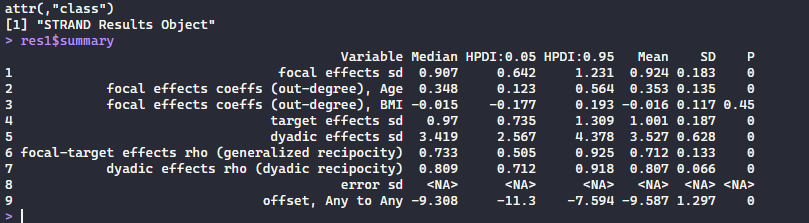

In [ ]:

m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(network),
    dyadic_predictors = srm.dyadic_predictors,
    focal_predictors = srm.focal_predictors,
    target_predictors = srm.focal_predictors,
    empty_edgl = tmp,
    blocks_mu_ij_padded = srm.blocks_mu_ij_padded,
    block_predictors = srm.block_predictors,
    num_blocks = srm.num_blocks,
    b_ij_sd = 0.1

)
def model(result_outcomes, dyadic_predictors, focal_predictors, target_predictors, 
          empty_edgl, blocks_mu_ij_padded, block_predictors, num_blocks, b_ij_sd):
    # Block ---------------------------------------
    B = block_prior2(empty_edgl, blocks_mu_ij_padded, block_predictors, num_blocks, b_ij_sd)
    
    ### SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_predictors, target_predictors)

    ## Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.poisson(jnp.exp(sr +  dr), obs=result_outcomes)


m.fit(model) 


sample: 100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s, 127 steps of size 3.47e-02. acc. prob=0.90]


In [497]:
m.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


KeyboardInterrupt: 

In [142]:
clean_index = m.tab_summary.index.str.replace(r"\[.*?\]", "", regex=True)
clean_index.unique()

Index(['dr_L', 'dr_raw', 'dr_rf', 'dr_sigma', 'dyad_effects', 'focal_effects',
       'sr_L', 'sr_raw', 'sr_rf', 'sr_sigma', 'target_effects'],
      dtype='object')

In [143]:
keywords = ["target_effects", "focal_effects", 'dr_sigma', 'dyad_effects', 'dr_sigma', 'sr_sigma']
keywords = "|".join(keywords)
m.tab_summary[m.tab_summary.index.str.contains(keywords)]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dr_sigma[0],0.73,0.36,0.02,1.11,0.13,0.10,10.11,101.52,NaN
dyad_effects[0],0.25,0.02,0.21,0.29,0.00,0.00,37.33,297.75,NaN
dyad_effects[1],-0.10,0.09,-0.24,0.04,0.00,0.00,357.12,194.29,NaN
focal_effects[0],0.26,0.26,-0.21,0.62,0.04,0.03,38.13,55.27,NaN
focal_effects[1],0.06,0.26,-0.36,0.44,0.04,0.03,45.91,107.00,NaN
sr_sigma[0],3.29,0.38,2.75,3.93,0.04,0.03,82.97,102.82,NaN
sr_sigma[1],3.20,0.37,2.66,3.86,0.04,0.03,74.79,125.75,NaN
target_effects[0],0.22,0.26,-0.18,0.61,0.04,0.03,42.76,70.14,NaN
target_effects[1],0.12,0.25,-0.27,0.47,0.04,0.03,36.67,91.48,NaN


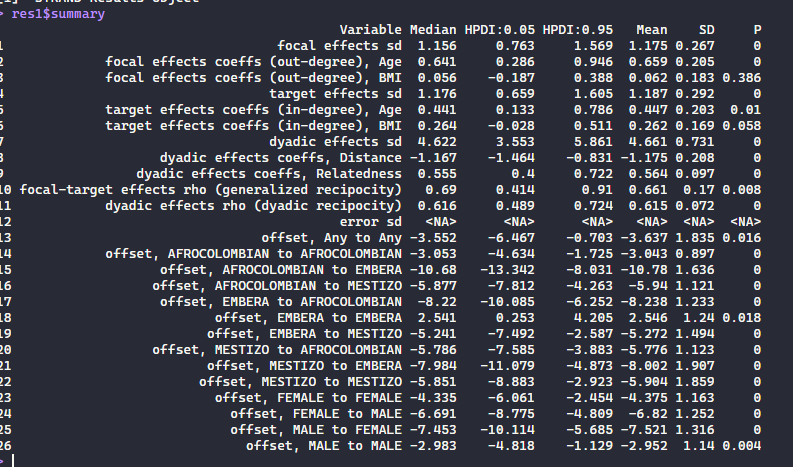

In [855]:
m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(srm.network),
    dyadic_predictors = srm.dyadic_predictors,
    focal_predictors = srm.focal_predictors,
    target_predictors = srm.focal_predictors,
    empty_edgl = tmp,
    blocks_mu_ij_padded = srm.blocks_mu_ij_padded,
    block_predictors = srm.block_predictors,
    num_blocks = srm.num_blocks,
    b_ij_sd = 0.1

)
def model(result_outcomes, dyadic_predictors, focal_predictors, target_predictors, 
          empty_edgl, blocks_mu_ij_padded, block_predictors, num_blocks, b_ij_sd):
    # Block ---------------------------------------
    B = block_prior2(empty_edgl, blocks_mu_ij_padded, block_predictors, num_blocks, b_ij_sd)

    ### SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_predictors, target_predictors)
#
    ## Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.poisson(jnp.exp(B + sr + dr), obs=result_outcomes)


m.fit(model) 


sample: 100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s, 1023 steps of size 5.49e-03. acc. prob=0.92]


In [736]:
blocks_edgl = srm.blocks_edgl
blocks_mu_ij = srm.blocks_mu_ij[1:]
names = srm.block_predictors_names
tmp = jnp.zeros_like(blocks_edgl[:,:,0])
sample = True

# --- Preparation for JIT ---
max_dim = max(b.shape[0] for b in blocks_mu_ij)
#    We find the largest dimension and pad the smaller arrays.
blocks_mu_ij_padded = [jnp.pad(b, [(0, max_dim - b.shape[0]), (0, max_dim - b.shape[1])]) for b in blocks_mu_ij]
blocks_mu_ij_padded = jnp.stack(blocks_mu_ij_padded)
num_blocks = len(blocks_mu_ij)
blocks_mu_ij_padded.shape

(2, 3, 3)

In [710]:
blocks_mu_ij_padded = [jnp.pad(b, [(0, max_dim - b.shape[0]), (0, max_dim - b.shape[1])], constant_values=jnp.nan) for b in blocks_mu_ij]
blocks_mu_ij_padded

[Array([[0.00083333, 0.00066227, 0.00066227],
        [0.00066227, 0.00052632, 0.00052632],
        [0.00066227, 0.00052632, 0.00052632]], dtype=float64),
 Array([[0.00047619, 0.00040522,        nan],
        [0.00040522, 0.00034483,        nan],
        [       nan,        nan,        nan]], dtype=float64)]

In [724]:
m.dist.normal(logit(current_block_mu), b_ij_sd, sample = True)

Array([[-7.77476554, -7.69593412,         nan],
       [-7.90450981, -7.81725303,         nan],
       [        nan,         nan,         nan]], dtype=float64)

In [738]:
i = 1
block_predictors = srm.block_predictors[:,1:]
current_block_mu = blocks_mu_ij_padded[i]
current_predictor = block_predictors[:, i]
b = m.dist.normal(logit(current_block_mu), b_ij_sd, sample = True)
update = m.net.block_prior_to_edglelist(current_predictor, b)
update

Array([[-7.83622493, -7.8356549 ],
       [-8.00416066, -8.00416066],
       [-7.83622493, -7.8356549 ],
       ...,
       [-7.83622493, -7.8356549 ],
       [-8.00416066, -8.00416066],
       [-7.8356549 , -7.83622493]], dtype=float64)

In [617]:
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

def update_tmp_body(i, tmp, blocks_padded, block_predictors, b_ij_sd):
    """
    The body of the fori_loop, executed for each block.
    This function should not be JIT-compiled directly, as it's part of the loop.
    """
    # Select the current block and predictor vector
    current_block_mu = blocks_padded[i]
    current_predictor = block_predictors[:, i]

    # Calculate 'b' using the helper functions
    b = m.dist.normal(logit(current_block_mu), b_ij_sd, sample = True)

    # Calculate the update for tmp
    # Note: The original code `tmp = tmp + ...` suggests an element-wise addition.
    # However, `block_prior_to_edgelist` may return a different shape than `tmp`.
    # Here, we assume the update needs to be summed to match tmp's shape.
    # This logic might need to be adjusted based on your specific requirements.
    update = m.net.block_prior_to_edglelist(current_predictor, b)
    tmp = tmp + jnp.sum(update, axis=1, keepdims=True) # Assumption: sum updates

    return tmp

@partial(jit, static_argnums=(3,)) # num_blocks is a static argument
def run_update_loop(initial_tmp, blocks_padded, block_predictors, num_blocks, b_ij_sd):
    """
    JIT-compatible function to run the update loop over all blocks.
    """
    # Create a lambda that captures the static arguments for fori_loop
    loop_body_fn = lambda i, tmp: update_tmp_body(i, tmp, blocks_padded, block_predictors, b_ij_sd)
    
    # Run the loop
    final_tmp = jax.lax.fori_loop(0, num_blocks, loop_body_fn, initial_tmp)
    
    return final_tmp



In [618]:
def update_tmp_body(i, tmp, blocks_padded, block_predictors, b_ij_sd):
    """
    The body of the fori_loop, executed for each block.
    This function should not be JIT-compiled directly, as it's part of the loop.
    """
    # Select the current block and predictor vector
    current_predictor = block_predictors[:, i]

    # Calculate 'b' using the helper functions
    b = m.dist.normal(logit(blocks_padded[i,:,:]), b_ij_sd, sample = True)

    # Calculate the update for tmp
    # Note: The original code `tmp = tmp + ...` suggests an element-wise addition.
    # However, `block_prior_to_edgelist` may return a different shape than `tmp`.
    # Here, we assume the update needs to be summed to match tmp's shape.
    # This logic might need to be adjusted based on your specific requirements.
    update = m.net.block_prior_to_edglelist(block_predictors[:, i], b)
    tmp = tmp + jnp.sum(update, axis=1, keepdims=True) # Assumption: sum updates
    return tmp

@partial(jit, static_argnums=(3,)) # num_blocks is a static argument
def run_update_loop(initial_tmp, blocks_padded, block_predictors, num_blocks, b_ij_sd):
    """
    JIT-compatible function to run the update loop over all blocks.
    """
    # Create a lambda that captures the static arguments for fori_loop
    loop_body_fn = lambda i, tmp: update_tmp_body(i, tmp, blocks_padded, block_predictors, b_ij_sd)
    
    # Run the loop
    final_tmp = jax.lax.fori_loop(0, num_blocks, loop_body_fn, initial_tmp)
    
    return final_tmp

In [670]:

block_predictors = srm.block_predictors[:,1:]
tmp = jnp.zeros_like(blocks_edgl[:,:,0])
blocks_padded
initial_tmp = tmp
num_blocks
b_ij_sd

update_tmp_body(1,tmp, blocks_padded, block_predictors, b_ij_sd)

Array([[-15.65128634, -15.65128634],
       [-15.92101922, -15.92101922],
       [-15.65128634, -15.65128634],
       ...,
       [-15.65128634, -15.65128634],
       [-15.92101922, -15.92101922],
       [-15.65128634, -15.65128634]], dtype=float64)

In [655]:
 m.net.block_prior_to_edglelist(current_predictor-1, b)

Array([[-7.79396575, -7.75347087],
       [-7.98762095, -7.98762095],
       [-7.79396575, -7.75347087],
       ...,
       [-7.79396575, -7.75347087],
       [-7.98762095, -7.98762095],
       [-7.75347087, -7.79396575]], dtype=float64)

In [671]:
blocks_padded

Array([[[0.00083333, 0.00066227, 0.00066227],
        [0.00066227, 0.00052632, 0.00052632],
        [0.00066227, 0.00052632, 0.00052632]],

       [[0.00047619, 0.00040522, 0.        ],
        [0.00040522, 0.00034483, 0.        ],
        [0.        , 0.        , 0.        ]]], dtype=float64)

In [631]:
i = 1
# Select the current block and predictor vector
current_block_mu = blocks_padded[i]
current_predictor = block_predictors[:, i]
# Calculate 'b' using the helper functions
b = m.dist.normal(logit(current_block_mu), b_ij_sd, sample = True)
# Calculate the update for tmp
# Note: The original code `tmp = tmp + ...` suggests an element-wise addition.
# However, `block_prior_to_edgelist` may return a different shape than `tmp`.
# Here, we assume the update needs to be summed to match tmp's shape.
# This logic might need to be adjusted based on your specific requirements.
update = m.net.block_prior_to_edglelist(current_predictor, b)
tmp = tmp + jnp.sum(update, axis=1, keepdims=True) # Assumption: sum updates
tmp

Array([[-inf, -inf],
       [-inf, -inf],
       [-inf, -inf],
       ...,
       [-inf, -inf],
       [-inf, -inf],
       [-inf, -inf]], dtype=float64)

In [ ]:
i = 0
initial_tmp = tmp
blocks_padded
block_predictors
b_ij_sd
current_block_mu = blocks_padded[i]
current_predictor = block_predictors[:, i]



In [533]:
blocks_edgl = srm.blocks_edgl
blocks_mu_ij = srm.blocks_mu_ij[1:]
names = srm.block_predictors_names
tmp = jnp.zeros_like(blocks_edgl[:,:,0])
sample = True

# --- Preparation for JIT ---
max_dim = max(b.shape[0] for b in blocks_mu_ij)
#    We find the largest dimension and pad the smaller arrays.
blocks_mu_ij_padded = [jnp.pad(b, [(0, max_dim - b.shape[0]), (0, max_dim - b.shape[1])]) for b in blocks_mu_ij]
blocks_mu_ij_padded = jnp.stack(blocks_mu_ij_padded)
num_blocks = len(blocks_mu_ij)


(2, 3, 3)

In [485]:
blocks_edgl = srm.blocks_edgl
blocks_mu_ij = srm.blocks_mu_ij[1:]
names = srm.block_predictors_names
tmp = jnp.zeros_like(blocks_edgl[:,:,0])
sample = True
im
for a in range(len(blocks_mu_ij)):
    b = m.dist.normal(m.net.logit(blocks_mu_ij[a]), b_ij_sd, sample = sample, name = f'b_{names[a]}', seed = )
    tmp = tmp + m.net.block_prior_to_edglelist(srm.block_predictors[:,a], blocks_mu_ij[a])
tmp

Array([[0.00087114, 0.00087114],
       [0.00087114, 0.00087114],
       [0.00087114, 0.00087114],
       ...,
       [0.00087114, 0.00087114],
       [0.00087114, 0.00087114],
       [0.00087114, 0.00087114]], dtype=float64)

In [ ]:
def model3(idx, result_outcomes, dyadic_predictors, dyad2, focal_individual_predictors, target_individual_predictors, Any, Merica, Quantum):
    # Block ---------------------------------------
    B_any = m.net.block_model(Any,1)
    B_Merica = m.net.block_model(Merica,3)
    B_Quantum = m.net.block_model(Quantum,2)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.poisson(jnp.exp(B_any + B_Merica + B_Quantum + sr + dr ), obs=result_outcomes)


#### block

In [ ]:
def block_model(M, group, N_group,  b_ij_sd = 2.5, sample = False): 
    N_vars = M.shape[0] 

    N_by_group = 
    Ngroups_byvar = 
    N_vars = M.shape[0]

    base_rate = jnp.tile(0.01, (N_group,N_group))
    base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
    mu_ij = base_rate/jnp.sqrt(jnp.outer(N_by_group, N_by_group))
    b = m.dist.normal(m.net.logit(mu_ij), b_ij_sd, sample = sample)
    return m.net.block_prior_to_edglelist(group, b)

In [ ]:
N_group = 3
b_ij_base_rate = 0.01
b_ij_sd = 2.5
b_ii_base_rate = 0.1
b_ii_sd = 2.5
name_b_ij = 'b_ij_Merica'
name_b_ii = 'b_ii_Merica'
sample = True
M = jnp.array([[ 149,1,1],[91,58,1],[116,21,12]])
_, N_by_group = jnp.unique(group, return_counts=True)  
def block_model(M, group, N_group,  b_ij_sd = 2.5, sample = False): 
    N_vars = M.shape[0] 
    N_max_groups = M.shape[1]

    base_rate = jnp.tile(0.01, (N_max_groups,N_max_groups))
    base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
    
    tmp = jnp.sqrt((vmap(lambda x: jnp.outer(x, x), in_axes=0, out_axes=0)(M)))
    mu_ij = vmap(lambda x: x/tmp, in_axes=0, out_axes=0)(base_rate)
    mu_ij = base_rate/jnp.sqrt(jnp.outer(N_by_group, N_by_group))
    b = m.dist.normal(m.net.logit(mu_ij), b_ij_sd, sample = sample)
    return m.net.block_prior_to_edglelist(group, b)

block_model(Quantum, 3, b_ij_sd = 2.5, sample = sample)

In [176]:
M = jnp.array([[ 149,1,1],[91,58,1],[116,21,12]])
N_vars = M.shape[0] 
N_max_groups = M.shape[1]
base_rate = jnp.tile(0.01, (N_max_groups,N_max_groups))
base_rate = base_rate.at[jnp.diag_indices_from(base_rate)].set(0.1)
tmp = jnp.sqrt((vmap(lambda x: jnp.outer(x, x), in_axes=0, out_axes=0)(M)))
mu_ij = vmap(lambda x: base_rate/x, in_axes=0, out_axes=0)(tmp)
b = m.dist.normal(m.net.logit(mu_ij), b_ij_sd, sample = sample)
b[0,:,:]

Array([[-8.61761899, -8.77198813, -6.58833011],
       [-8.2279576 ,  1.28490077, -1.94671872],
       [-7.68842547, -9.38559376, -5.28041522]], dtype=float64)

In [180]:
grp_stack = jnp.stack([Any, Merica, Quantum ], axis = 1)
grp_stack.shape

(50, 3)

In [277]:
tmp2 = vmap(lambda x: m.net.vec_node_to_edgle(jnp.stack([ids, ids], axis= 1)))(jnp.zeros(N_vars))
tmp2
tmp2[:,200,:].shape

(3, 2)

#### SRM MODEL

In [ ]:
# Building model and sampling it ------------------
from BI import bi
import jax.numpy as jnp
from jax import jit
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'][0,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
dyad2 = data['dyadic_predictors'][1,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
Any = data['block_predictors'][0,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Merica  = data['block_predictors'][1,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Quantum  = data['block_predictors'][2,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
ids = jnp.arange(0,data['N_id'][0])
idx = m.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))

@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model3(idx, result_outcomes, dyadic_predictors, dyad2, focal_individual_predictors, target_individual_predictors, Any, Merica, Quantum):
    # Block ---------------------------------------
    B_any = m.net.block_model(Any,1)
    B_Merica = m.net.block_model(Merica,3)
    B_Quantum = m.net.block_model(Quantum,2)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.poisson(jnp.exp(B_any + B_Merica + B_Quantum + sr + dr ), obs=result_outcomes)

m.data_on_model = dict(
    idx = idx,
    Any = Any, 
    Merica = Merica, 
    Quantum = Quantum,
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = m.net.mat_to_edgl(kinship),
    dyad2 = m.net.mat_to_edgl(dyad2),
    focal_individual_predictors = data['individual_predictors'].reshape(1,50),
    target_individual_predictors = data['individual_predictors'].reshape(1,50)
)

m.fit(model3) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]',
'b_ii_Any[0]',
'b_ii_Merica[0]',
'b_ii_Merica[1]',
'b_ii_Merica[2]',
'b_ii_Quantum[0]',
'b_ii_Quantum[1]',
'b_ij_Merica[0, 0]',
'b_ij_Merica[0, 1]',
'b_ij_Merica[1, 0]',
'b_ij_Merica[1, 1]',
'b_ij_Merica[2, 0]',
'b_ij_Merica[2, 1]',
'b_ij_Quantum[0, 0]',
'b_ij_Quantum[0, 1]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2


In [14]:
%%R
getwd()
library(STRAND)
load('tests/STRAND/STRAND sim sr dr block.Rdata')
res$summary

                                            Variable Median HPDI:0.05 HPDI:0.95
1                                   focal effects sd  2.204     1.845     2.624
2            focal effects coeffs (out-degree), Mass  1.652     0.716     2.472
3                                  target effects sd  1.516     1.165     1.849
4            target effects coeffs (in-degree), Mass  0.842     0.072     1.508
5                                  dyadic effects sd   1.47     1.326     1.629
6                     dyadic effects coeffs, Kinship  0.423    -0.491     1.331
7  focal-target effects rho (generalized recipocity)  0.609     0.402     0.762
8             dyadic effects rho (dyadic recipocity)  0.734     0.568     0.899
9                                 offset, Any to Any -0.821    -3.052     1.559
10                              offset, Blue to Blue -4.146     -5.55    -2.174
11                               offset, Blue to Red -9.071   -11.099    -7.284
12                             offset, B

#### Sender receiver, dyadic effects, block model and exposure model

Binomial with rates

## BISONR (WIP)

In [3]:
df = pd.read_csv('tests/STRAND/bison sim data.csv')
df.shape

(45, 7)

### Binary

In [384]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

NameError: name 'df' is not defined

In [5]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [9]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = BI.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)